# Standardalone Driver of LIM/DMD

## Load modules

In [1]:
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from lim_mod_pt import LIM

from read_AM_index_mod import Reanalysis, CMIP6

import torch
from torch import linalg as la

gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")

plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]

## Load data

Reading from saved data ......
JRA55
t.shape = torch.Size([150]), y.shape = torch.Size([56, 150, 8])


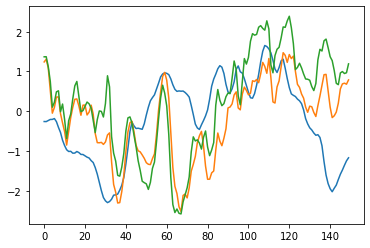

In [2]:
# use plev
D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55', \
    annual_cycle_fft=2, running_mean=0, save_index=False)
## use all the levels
# D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2016, name='JRA55', \
#    annual_cycle_fft=4, running_mean=0, save_index=False)

if True:
    # load the AM index
    D0.y, _ = D0.slice_data(month_start=11, len_slice=150, month_start2=8)
    D0.y = torch.from_numpy(D0.y.astype('float32'))
    # D0.y = torch.from_numpy(D0.y.astype('float64'))
    print(D0.name)
    y = D0.y
    t = torch.linspace(0, D0.y.shape[1]-1, D0.y.shape[1], dtype=D0.y.dtype)
    p = D0.level

else:
    # load red noise
    from read_AM_index_mod import get_red_noise

    y = torch.empty((56, 150, 8))
    data_size = y.shape[0]*y.shape[1]
    for n in range(6):
        gamma = [0.06*(n+1)]
        print(1/gamma[0])
        _, yy = get_red_noise(gamma=gamma, data_size=data_size, seed=n*13)
        y[:, :, n] = yy.reshape(y.shape[0], y.shape[1])
    y[:,:,6:] = 0.1*y[:,:,0:2] + 0.9*y[:,:,4:6]
    t = torch.linspace(0, y.shape[1]-1, y.shape[1], dtype=y.dtype)
    p = np.array(plev)

print(f't.shape = {t.shape}, y.shape = {y.shape}')
plt.plot(y[0,:,::3])

In [3]:
def visualization():
    model = LIM(y, hyp_param, verbose=True)
    # print(model.vl.shape)

    # forecasting
    yf = model.forecast(y[:, :-forecast_time, :], t[:forecast_time+1])
    sn = np.sign(model.vr[np.isin(p, 10), 0].real)
    # print(f'y.shape={y.shape}, yf.shape={yf.shape}')

    # plotting vr, vl
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1,2,1)
    plt.plot(model.vr[:, 0].real*sn, p, label='Real')
    plt.plot(model.vr[:, 0].imag*sn, p, label='Imag')
    plt.plot(p*0, p, '--k')

    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    ax = fig.add_subplot(1,2,2)
    plt.plot(model.vl[:, 0].real*sn, p, label='Real')
    plt.plot(model.vl[:, 0].imag*sn, p, label='Imag')
    plt.plot(p*0, p, '--k')

    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    # # finding and plotting optimals
    # rr = np.ones((len(p), 1))
    # rr [p<200] = 0
    # print(rr)
    # N = torch.from_numpy((rr @ rr.T).astype('float32'))
    # N = torch.eye(len(p))
    # print(f'N.shape={N.shape}')
    
    # w, vr = model.optimals(t[:forecast_time+1], method='eig', N=N)

    # fig = plt.figure(figsize=(12, 5))
    # ax = fig.add_subplot(1,2,1)
    # plt.plot(vr[forecast_time, :], p, label='V')
    # plt.plot(p*0, p, '--k')
    # plt.gca().invert_yaxis()
    # plt.ylabel('Pressure (hPa)')
    # plt.yscale('log')
    # plt.yticks([10, 30, 100, 300, 1000])
    # plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # plt.legend()

    # ax = fig.add_subplot(1,2,2)
    # plt.plot(w)
    # print(f'Amplification =\n{w}')

    U, s, V = model.optimals(t[:forecast_time+1], method='svd')
    sn = np.sign(U[forecast_time, np.isin(p, 10)])

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1,2,1)
    plt.plot(U[forecast_time, :]*sn, p, label='U')
    plt.plot(V[forecast_time, :]*sn, p, label='V')
    plt.plot(p*0, p, '--k')
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    ax = fig.add_subplot(1,2,2)
    plt.plot(s**2)
    # print(f'Amplification = {s**2}')


hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'DMD': {'r_alpha': 0.004, 'r_ord': 2, 'r_optimal': None, 'r_forecast': 5, 'eig_method': 'pinv'}}}
r_opt=5: % of var=99.939468, B_norm=0.116438, X_err=0.529438, s=1.098997
POP e-folding timescales =
 tensor([23.5325, 23.5325, 10.3910,  7.3130,  4.5898])


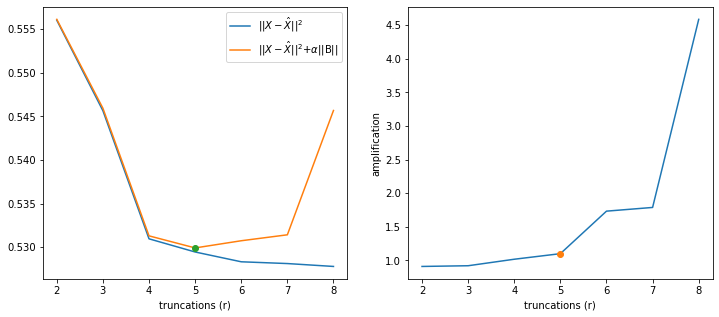

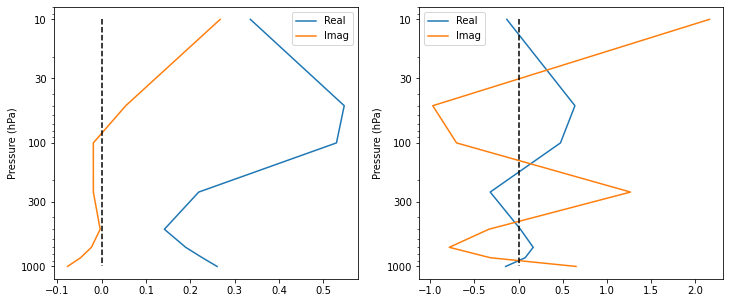

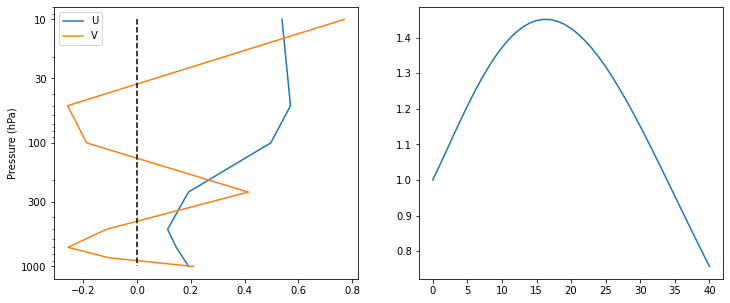

In [4]:
hyp_param = dict(lim = dict(method = 'DMD',
                            lag_time = 5,
                            DMD = dict( r_alpha = 4e-3,
                                        r_ord   = 2,
                                        r_optimal = None,
                                        r_forecast = 5,
                                        eig_method = 'pinv',
                                       )
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

forecast_time = 40
visualization()

hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'DMD': {'r_alpha': 0.001, 'r_ord': 1, 'r_optimal': None, 'r_forecast': 5, 'eig_method': 'pinv'}}}
r_opt=5: % of var=99.939468, B_norm=2.048778, X_err=0.529438, s=1.098997
POP e-folding timescales =
 tensor([23.5325, 23.5325, 10.3910,  7.3130,  4.5898])


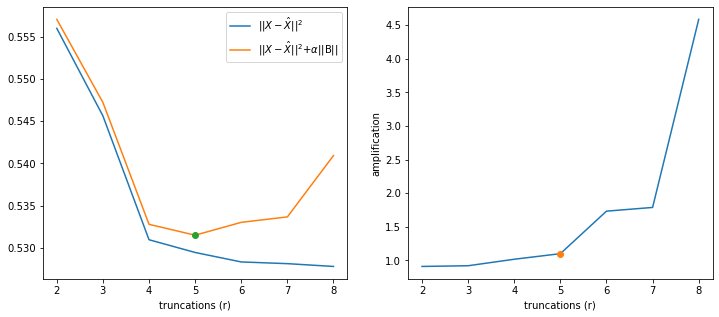

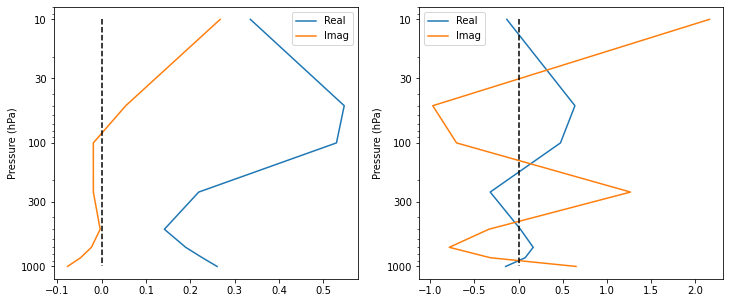

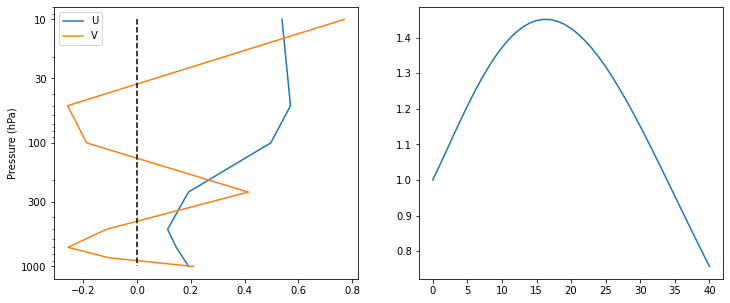

In [5]:
hyp_param = dict(lim = dict(method = 'DMD',
                            lag_time = 5,
                            DMD = dict( r_alpha = 1e-3,
                                        r_ord   = 1,
                                        r_optimal = None,
                                        r_forecast = 5,
                                        eig_method = 'pinv',
                                       )
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

forecast_time = 40
visualization()